## Wiki data impute test
- Wiki data have missing values especially for unpopular projects.
- The entire dataset have approximately 5% missing values.
- Things have tried before: 1. pad the missing values to be 0s 2. leave them as NULL so they are not taken account in the RNN model training.
- Here we see how different imputation looks like. And a bit of my thoughts on it.

In [77]:
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import heapq

In [78]:
# important window definition
prediction_length = 48
context_length = 72
day = 24
week = 148
month = 720
year = 8760

In [79]:
def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat is not None:
        obj["cat"] = cat
    return obj

def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

In [80]:
# get the Time Series data and corresponding wiki project name
def get_ts(data_location,label_location,freq):
    df_ts = pd.read_json(data_location, lines=True)
    num_pt = min(len(df_ts.iloc[1, 1]), 100000)
    print('use first ', num_pt, ' points in a time series')
    num_ts = len(df_ts)

    time_series_wiki = []
    for k in range(num_ts):
        t0 = df_ts.iloc[k, 0]
        data = df_ts.iloc[k, 1][:num_pt]
        index = pd.DatetimeIndex(start=t0, freq=freq, periods=num_pt)
        time_series_wiki.append(pd.Series(data=data, index=index))
        
    with open(label_location) as f:
        wp_list = f.read().splitlines()  
        
    return time_series_wiki, wp_list

In [81]:
label_location = 'wp_full-20180101-20190101_get.txt'    
data_location = 'test_1year.json'
freq = 'H'

time_series_wiki, wp_list = get_ts(data_location,label_location,freq)

use first  8784  points in a time series


In [82]:
list_0val = []
list_0val_ff = []
list_0val_interp = []
for tm in time_series_wiki:    
    tm_null = tm.replace(to_replace=0, value=np.nan, inplace = False)
    tm_fillfw = tm_null.fillna(method = 'ffill')
    tm_interp = tm_null.interpolate(method = 'linear', limit_area = 'inside',  limit = 3)
    if (tm == 0).sum() > 0:
        list_0val.append((tm == 0).sum()/len(tm))
        list_0val_ff.append(tm_fillfw.isnull().sum()/len(tm))
        list_0val_interp.append(tm_interp.isnull().sum()/len(tm))

print(sum(list_0val), sum(list_0val_ff), sum(list_0val_interp))

42.00295992714029 0.024020947176684872 14.762408925318757


In [83]:
encoding = "utf-8"

with open("imputed_data.json", 'wb') as fp:
    for ts in time_series_wiki:
        tm_null = ts.replace(to_replace=0, value=np.nan, inplace = False)
        ts_interp = tm_null.interpolate(method = 'linear', limit_area = 'inside',  limit = 3)
        fp.write(series_to_jsonline(ts_interp).encode(encoding))
        fp.write('\n'.encode(encoding))

Text(0,0.5,'# of time series')

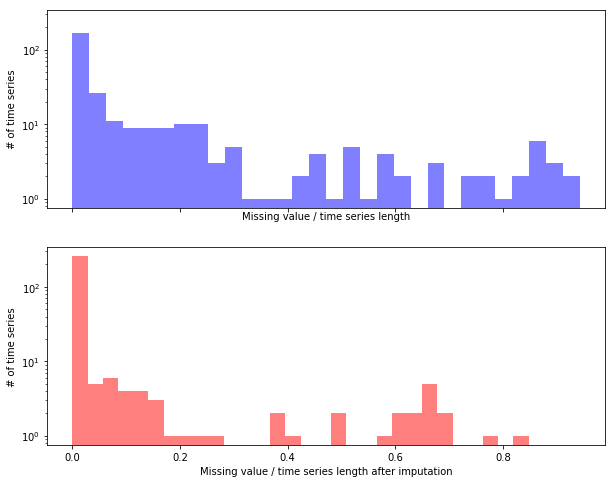

In [84]:
fig, ax = plt.subplots(2, 1, sharex = True, sharey = True, figsize=(10, 8))
ax[0].hist(list_0val, bins = 30, alpha = 0.5, color = 'b')
ax[0].set_yscale('log')
ax[0].set_xlabel('Missing value / time series length')
ax[0].set_ylabel('# of time series')
ax[1].hist(list_0val_interp, bins = 30, alpha = 0.5, color = 'r')
ax[1].set_xlabel('Missing value / time series length after imputation')
ax[1].set_ylabel('# of time series')

## Examples of imputation: fill forward, fill mean, linear interpolation

### A bit of my thoughts:
1. No matter what imputation method we use, we inevitably change the time series: the frequency response is totally altered -- something huge in signal processing, so I would suggest proceed with caution.
2. What the deepAR model does is to give a conditional probability distribution of the future points, given the past points. So if we do any kind of imputation, we are essentially adding information in there. I think just take whatever we have to infer the conditional probability distribution makes more sense mathematically.

In [85]:
tm = time_series_wiki[12]

mean = 0.4929417122040073  std = 5.00273820486491


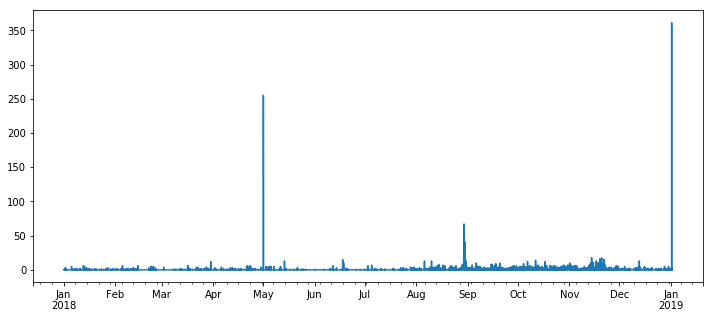

In [86]:
tm.plot(figsize = (12,5))
print('mean = {}'.format(tm.mean()), ' std = {}'.format(tm.std()))

In [88]:
print('total zero values',(tm == 0).sum(), ' length ', len(tm))
#tm[-500:-300]

total zero values 7470  length  8784


In [89]:
tm_null = tm.replace(to_replace=0, value=np.nan, inplace = False)

In [90]:
tm_null.isnull().sum()

7470

In [91]:
tm_fillmean = tm_null.fillna(value = tm_null.mean())
print(tm_fillmean.isnull().sum())

0


In [92]:
tm_fillfw = tm_null.fillna(method = 'ffill')
print(tm_fillfw.isnull().sum())

15


In [97]:
tm_interp = tm_null.interpolate(method = 'linear', limit_area = 'inside', limit = 3)
print(tm_interp.isnull().sum())

5481


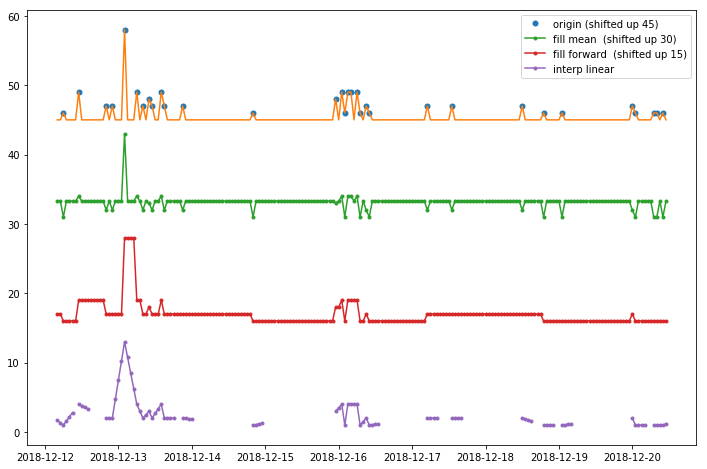

In [112]:
plt.figure(figsize = (12,8))
plt.plot(tm_null[-500:-300]+ 45, '.', ms = 10,  label = 'origin (shifted up 45)')
plt.plot(tm[-500:-300]+ 45)
plt.plot(tm_fillmean[-500:-300] + 30, '.-', label = 'fill mean  (shifted up 30)')
plt.plot(tm_fillfw[-500:-300] + 15, '.-', label = 'fill forward  (shifted up 15)')
plt.plot(tm_interp[-500:-300], '.-', label = 'interp linear')
plt.legend(loc = 'best')